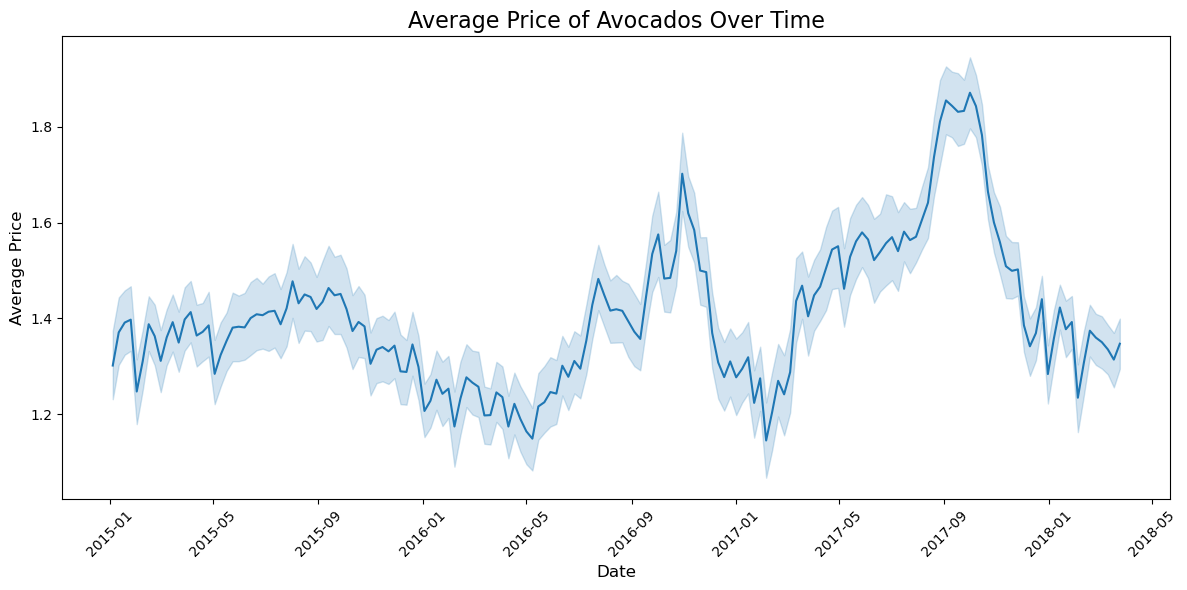

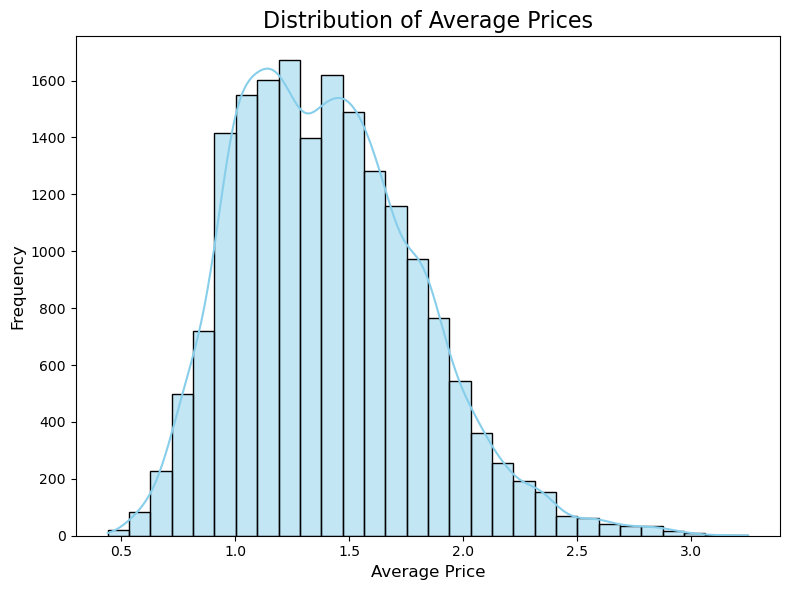

C:\Users\Jerry\AppData\Local\Temp\ipykernel_28852\4108312466.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='type_organic', y='AveragePrice', palette='pastel')


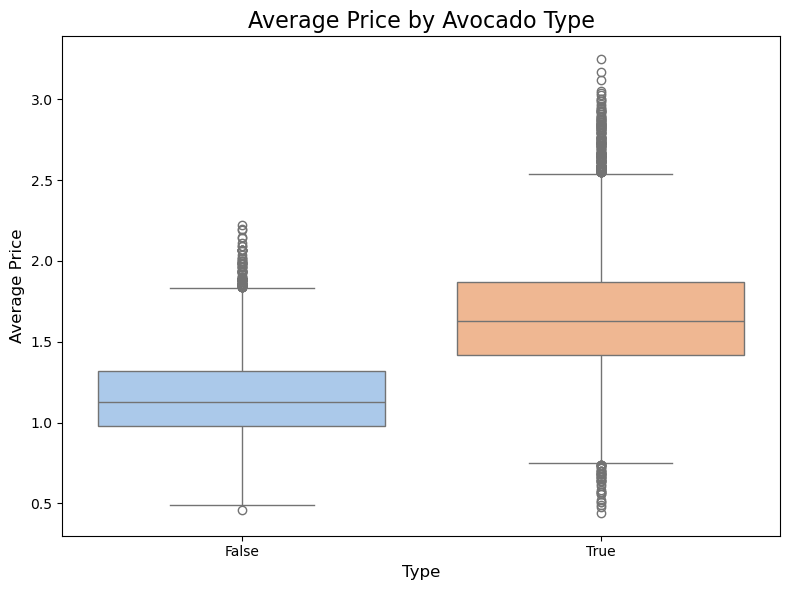

C:\Users\Jerry\AppData\Local\Temp\ipykernel_28852\4108312466.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=melted_top_regions, x='Region', y='AveragePrice', palette='coolwarm')


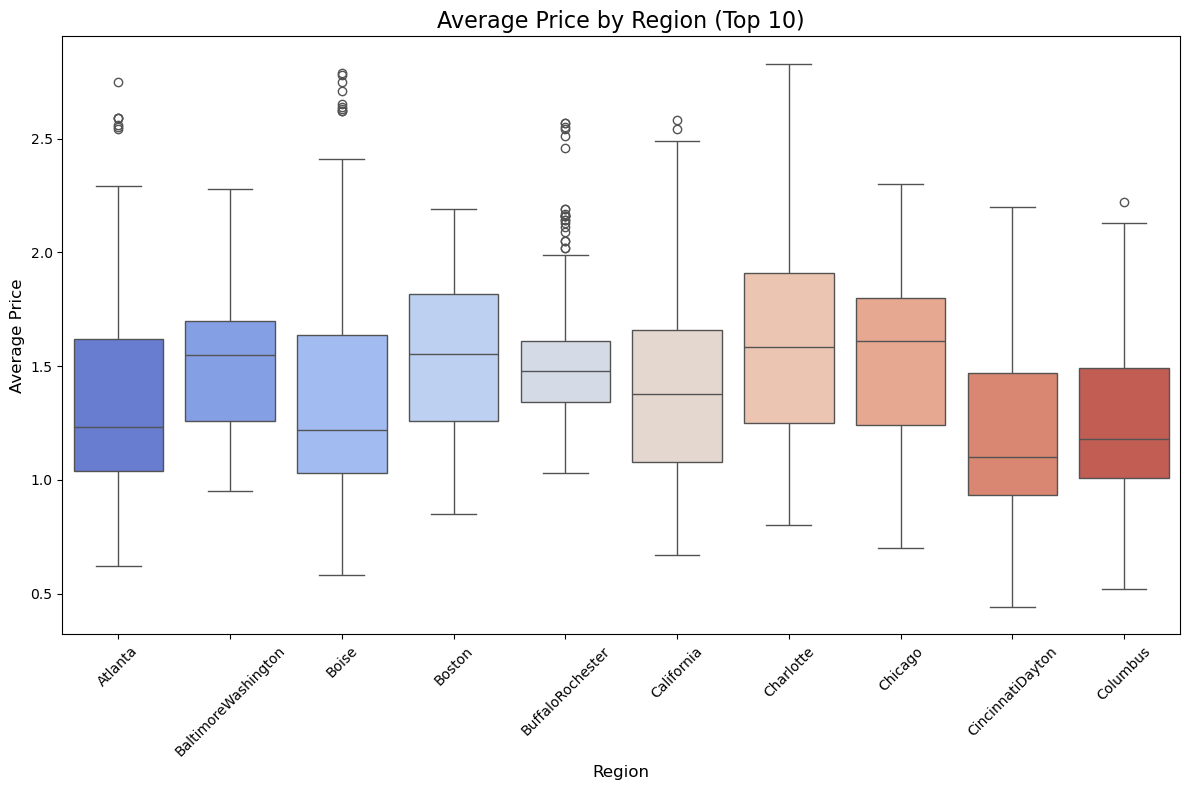

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

path = r"C:\Users\Jerry\Desktop\MA\UIUC\CS441\final\avocado.csv"
data = pd.read_csv(path)

data.isnull().sum() # no missing data

data = pd.get_dummies(data, columns=['type', 'region'], drop_first=True)

data['Date'] = pd.to_datetime(data['Date'])

# Plot 1: Average Price over Time
plt.figure(figsize=(12, 6))
sns.lineplot(data=data, x='Date', y='AveragePrice')
plt.title('Average Price of Avocados Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Price', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot 2: Distribution of Average Price
plt.figure(figsize=(8, 6))
sns.histplot(data['AveragePrice'], kde=True, bins=30, color='skyblue')
plt.title('Distribution of Average Prices', fontsize=16)
plt.xlabel('Average Price', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.tight_layout()
plt.show()

# Plot 3: Average Price by Type
plt.figure(figsize=(8, 6))
sns.boxplot(data=data, x='type_organic', y='AveragePrice', palette='pastel')
plt.title('Average Price by Avocado Type', fontsize=16)
plt.xlabel('Type', fontsize=12)
plt.ylabel('Average Price', fontsize=12)
plt.tight_layout()
plt.show()

# Plot 4: top 10 regions
region_columns = [col for col in data.columns if col.startswith('region_')]
region_totals = {col: data[col].sum() for col in region_columns}
top_regions = sorted(region_totals, key=region_totals.get, reverse=True)[:10]
top_regions_data_encoded = data.loc[data[top_regions].any(axis=1), ['AveragePrice'] + top_regions]

melted_top_regions = pd.melt(
    top_regions_data_encoded,
    id_vars='AveragePrice',
    value_vars=top_regions,
    var_name='Region',
    value_name='Presence'
)

melted_top_regions = melted_top_regions[melted_top_regions['Presence'] == 1]

melted_top_regions['Region'] = melted_top_regions['Region'].str.replace('region_', '')

plt.figure(figsize=(12, 8))
sns.boxplot(data=melted_top_regions, x='Region', y='AveragePrice', palette='coolwarm')
plt.title('Average Price by Region (Top 10)', fontsize=16)
plt.xlabel('Region', fontsize=12)
plt.ylabel('Average Price', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [2]:
#%% random forest

data = data.drop(columns=['Unnamed: 0'])

data['Date'] = pd.to_datetime(data['Date'])
data['Month'] = data['Date'].dt.month # extract month as a new feature
data = data.drop(columns=['Date'])

x = data.drop(columns=['AveragePrice']) # features
y = data['AveragePrice'] # target

# 70% train, 15% val, 15% test
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.3, random_state=0)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=0)


max_depth = [2, 4, 8, 16, 32, 64, 128]
max_features = [1/3, 2/3, 1]


'''
rf_model = RandomForestRegressor(n_estimators=100, max_depth=None, random_state=42)
rf_model.fit(x_train, y_train)
y_val_pred = rf_model.predict(x_val)
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

y_test_pred = rf_model.predict(x_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
'''

results_rf = {}
for depth in max_depth:
    for features in max_features:
        model_rf = RandomForestRegressor(max_depth = depth, max_features = features, random_state = 0)
        model_rf.fit(x_train, y_train)
        
        y_train_pred = model_rf.predict(x_train)
        y_val_pred = model_rf.predict(x_val)
        
        train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
        val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
        
        r2 = r2_score(y_val, y_val_pred)
        
        results_rf[(depth, features)] = {'train_rmse': train_rmse, 'val_rmse': val_rmse, 'r2': r2}
        print(f"depth: {depth}, max features for split: {features}, val rmse: {val_rmse}, r2 score: {r2}")

rf_sorted = pd.DataFrame.from_dict(results_rf, orient='index')
rf_sorted.index = pd.MultiIndex.from_tuples(rf_sorted.index, names=['max_depth', 'max_features_ratio'])
rf_sorted = rf_sorted.sort_values(by='val_rmse', ascending=False)

best_depth = 64
best_max_features = 2/3

x_train_val = pd.concat([x_train, x_val])
y_train_val = pd.concat([y_train, y_val])

final_model_rf = RandomForestRegressor(max_depth=best_depth, max_features=best_max_features, random_state=0)
final_model_rf.fit(x_train_val, y_train_val)

y_test_pred = final_model_rf.predict(x_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

test_r2 = r2_score(y_test, y_test_pred)


depth: 2, max features for split: 0.3333333333333333, val rmse: 0.29729297779537234, r2 score: 0.4398931702475415
depth: 2, max features for split: 0.6666666666666666, val rmse: 0.29488806017784175, r2 score: 0.4489183584475148
depth: 2, max features for split: 1, val rmse: 0.3653858149033918, r2 score: 0.1539326568527648
depth: 4, max features for split: 0.3333333333333333, val rmse: 0.2675144755001083, r2 score: 0.5464803169547744
depth: 4, max features for split: 0.6666666666666666, val rmse: 0.25932925300137394, r2 score: 0.5738086958364039
depth: 4, max features for split: 1, val rmse: 0.3385708858277273, r2 score: 0.27355826702412533
depth: 8, max features for split: 0.3333333333333333, val rmse: 0.20478908211711916, r2 score: 0.734224364605496
depth: 8, max features for split: 0.6666666666666666, val rmse: 0.19558047821101263, r2 score: 0.7575888602261407
depth: 8, max features for split: 1, val rmse: 0.29755132006593454, r2 score: 0.43891930169695814
depth: 16, max features for

In [3]:
print(final_model_rf)

RandomForestRegressor(max_depth=64, max_features=0.6666666666666666,
                      random_state=0)


In [4]:
print(f'test rmse: {test_rmse}')
print(f'test r2: {test_r2}')

test rmse: 0.12672863286516728
test r2: 0.9027251706900341


In [6]:
validation_results = [
    {'max_depth': depth, 'max_features': features, **metrics}
    for (depth, features), metrics in results_rf.items()
]

validation_df = pd.DataFrame(validation_results)

validation_df.rename(
    columns={'train_rmse': 'Train RMSE', 'val_rmse': 'Validation RMSE', 'r2': 'Validation R2'},
    inplace=True
)

validation_df = validation_df.sort_values(by='Validation RMSE', ascending=True)

print(validation_df)

    max_depth  max_features  Train RMSE  Validation RMSE  Validation R2
16         64      0.666667    0.047483         0.125817       0.899682
19        128      0.666667    0.047483         0.125817       0.899682
18        128      0.333333    0.047705         0.125835       0.899652
15         64      0.333333    0.047705         0.125835       0.899652
12         32      0.333333    0.047948         0.126305       0.898901
13         32      0.666667    0.047539         0.126867       0.898000
10         16      0.666667    0.070065         0.131878       0.889783
17         64      1.000000    0.050579         0.132027       0.889535
20        128      1.000000    0.050584         0.132141       0.889344
9          16      0.333333    0.080231         0.137442       0.880288
14         32      1.000000    0.109288         0.159184       0.839417
7           8      0.666667    0.182285         0.195580       0.757589
6           8      0.333333    0.192977         0.204789       0